In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import OneClassSVM
from imblearn.over_sampling import SMOTE
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
import lime
import lime.lime_tabular

/tmp/ipykernel_2773125/1979477410.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
#data importation
import pandas as pd
import numpy as np

# Read the cleaned CSV file
fraud_data = pd.read_csv('CleanedFraudData.csv')

# Display the first few rows
fraud_data.head()


,Unnamed: 0,fraud_bool,income,name_email_similarity,salary,prev_address_months_count,current_address_months_count,customer_age,date_of_birth,days_since_request,...,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month,email_domain
0,2,0.0,0.8,0.996707,122830.0,9.0,14.0,40.0,1982-01-01,0.012316,...,200.0,0.0,INTERNET,22.730559,windows,0.0,1.0,0.0,January,aol.com
1,3,0.0,0.6,0.475100,83960.0,11.0,14.0,30.0,1990-09-05,0.006991,...,200.0,0.0,INTERNET,15.215816,linux,1.0,1.0,0.0,January,aol.com
2,6,0.0,0.2,0.773085,38585.0,22.0,4.0,40.0,1984-04-22,0.006919,...,200.0,0.0,INTERNET,28.199923,x11,1.0,1.0,0.0,January,zoho.com
3,8,0.0,0.3,0.523655,40031.0,21.0,2.0,30.0,1992-11-08,0.035206,...,200.0,0.0,INTERNET,5.329387,other,1.0,1.0,0.0,January,business.org
4,18,0.0,0.2,0.527751,37010.0,13.0,114.0,20.0,1999-09-25,0.003171,...,200.0,0.0,INTERNET,2.838194,windows,1.0,2.0,0.0,January,consulting.co


In [3]:
#shape of data
fraud_data.shape

(244191, 36)

In [4]:
# Data Types
fraud_data.dtypes

Unnamed: 0                            int64
fraud_bool                          float64
income                              float64
name_email_similarity               float64
salary                              float64
prev_address_months_count           float64
current_address_months_count        float64
customer_age                        float64
date_of_birth                        object
days_since_request                  float64
intended_balcon_amount              float64
payment_type                         object
zip_count_4w                         object
velocity_6h                         float64
velocity_24h                        float64
velocity_4w                         float64
bank_branch_count_8w                float64
date_of_birth_distinct_emails_4w    float64
employment_status                    object
credit_risk_score                   float64
email_is_free                       float64
housing_status                       object
phone_home_valid                

In [5]:
# Removal of some redundant columns
fraud_data = fraud_data.drop(['name_email_similarity','salary','date_of_birth',
                              'zip_count_4w','income','Unnamed: 0'], axis=1)


In [6]:
# create cross tab for actual data
fraud_prop = pd.crosstab(index = fraud_data['fraud_bool'], columns = "prop")/pd.crosstab(index = fraud_data['fraud_bool'], columns = "prop").sum()
print(fraud_prop )

col_0         prop
fraud_bool        
0.0         0.9969
1.0         0.0031


In [7]:
pd.crosstab(index = fraud_data['fraud_bool'], columns = "count")

col_0,count
fraud_bool,
0.0,243434
1.0,757


## Creating Train and Test data

In [8]:
train = fraud_data.groupby("fraud_bool").sample(n = 500, random_state = 1234)
test = fraud_data.loc[fraud_data.index.difference(train.index)]
train.head()

,fraud_bool,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,velocity_6h,velocity_24h,velocity_4w,...,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month,email_domain
156658,0.0,30.0,292.0,20.0,8.530328,31.862383,AA,10342.0,5998.0,5180.0,...,200.0,0.0,INTERNET,8.406942,other,0.0,1.0,0.0,May,yandex.com
63213,0.0,52.0,17.0,40.0,0.004717,-0.892632,AD,9698.0,4916.0,5617.0,...,200.0,0.0,INTERNET,3.214909,other,0.0,1.0,0.0,March,gmail.com
196385,0.0,20.0,0.0,30.0,1.221956,-0.683191,AB,3169.0,3642.0,4295.0,...,200.0,0.0,INTERNET,6.651120,other,1.0,1.0,0.0,July,yandex.com
97557,0.0,52.0,16.0,50.0,0.007483,-0.443474,AC,8974.0,5464.0,5191.0,...,1000.0,0.0,INTERNET,5.246280,linux,1.0,1.0,0.0,March,consulting.co
181264,0.0,24.0,4.0,20.0,0.030740,-1.001902,AC,7054.0,3243.0,4373.0,...,200.0,0.0,INTERNET,13.476022,other,0.0,1.0,0.0,June,finance.pro


In [9]:
pd.crosstab(index = train['fraud_bool'], columns = "count")



col_0,count
fraud_bool,
0.0,500
1.0,500


In [10]:
pd.crosstab(index = test['fraud_bool'], columns = "count")

col_0,count
fraud_bool,
0.0,242934
1.0,257


In [11]:
# filling in number dtypes with median and flagging with missing 
train_o = train.copy()
num_cols = train_o.select_dtypes(include='number').columns

for col in num_cols:
    if train_o[col].isnull().any():
        # Create missing flag column
        train_o[f'{col}_was_missing'] = train_o[col].isnull().astype(int)

        # Impute with median
        median = train_o[col].median()
        train_o[col] = train_o[col].fillna(median)
print(train_o.columns)

Index(['fraud_bool', 'prev_address_months_count',
       'current_address_months_count', 'customer_age', 'days_since_request',
       'intended_balcon_amount', 'payment_type', 'velocity_6h', 'velocity_24h',
       'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'employment_status',
       'credit_risk_score', 'email_is_free', 'housing_status',
       'phone_home_valid', 'phone_mobile_valid', 'bank_months_count',
       'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'source',
       'session_length_in_minutes', 'device_os', 'keep_alive_session',
       'device_distinct_emails_8w', 'device_fraud_count', 'month',
       'email_domain'],
      dtype='object')


In [12]:
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print(train_o.dtypes)


fraud_bool                          float64
prev_address_months_count           float64
current_address_months_count        float64
customer_age                        float64
days_since_request                  float64
intended_balcon_amount              float64
payment_type                         object
velocity_6h                         float64
velocity_24h                        float64
velocity_4w                         float64
bank_branch_count_8w                float64
date_of_birth_distinct_emails_4w    float64
employment_status                    object
credit_risk_score                   float64
email_is_free                       float64
housing_status                       object
phone_home_valid                    float64
phone_mobile_valid                  float64
bank_months_count                   float64
has_other_cards                     float64
proposed_credit_limit               float64
foreign_request                     float64
source                          

In [13]:
# creating X and Y and creating dummies for categorical data 
predictors = train_o.drop(columns=['fraud_bool'])
predictors = pd.get_dummies(predictors, drop_first=True)
predictors = predictors.astype(float)

X = predictors
y = train_o['fraud_bool']

In [14]:
# using Pearson's square to sort data and determine association, 
# Use p-value of 0.002 depending on the data siize
from sklearn.feature_selection import SelectKBest, chi2, f_classif

# Separate categorical (dummy) vs. continuous features
categorical_features = [col for col in X.columns if X[col].nunique() == 2]
continuous_features = [col for col in X.columns if X[col].nunique() > 2]

X_cat = X[categorical_features]
X_cont = X[continuous_features]

# Fit SelectKBest for Categorical Variables
selector = SelectKBest(score_func=chi2, k='all')  # 'all' keeps all features for scoring
selector.fit(X_cat, y)

# Create a DataFrame with feature names, Chi2-scores, and p-values
scores_cat_df = pd.DataFrame({
    'Feature': X_cat.columns,
    'Chi2_score': selector.scores_,
    'p_value': selector.pvalues_
})

# Filter for features with p-value < 0.002
selected_cat_features = scores_cat_df[scores_cat_df['p_value'] < 0.002]['Feature']

# Fit SelectKBest for Continous Variables
selector = SelectKBest(score_func=f_classif, k='all')  # 'all' keeps all features for scoring
selector.fit(X_cont, y)

# Create a DataFrame with feature names, F-scores, and p-values
scores_cont_df = pd.DataFrame({
    'Feature': X_cont.columns,
    'F_score': selector.scores_,
    'p_value': selector.pvalues_
})

# Filter for features with p-value < 0.002
selected_cont_features = scores_cont_df[scores_cont_df['p_value'] < 0.002]['Feature']

# Create a new DataFrame with only those selected columns
X_reduced = X[selected_cat_features.tolist() + selected_cont_features.tolist()]

X_reduced.head()

,phone_home_valid,has_other_cards,foreign_request,keep_alive_session,payment_type_AC,employment_status_CB,employment_status_CF,housing_status_BB,device_os_other,device_os_windows,month_August,prev_address_months_count,current_address_months_count,customer_age,intended_balcon_amount,date_of_birth_distinct_emails_4w,credit_risk_score,proposed_credit_limit,device_distinct_emails_8w
156658,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,30.0,292.0,20.0,31.862383,9.0,91.0,200.0,1.0
63213,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,52.0,17.0,40.0,-0.892632,12.0,122.0,200.0,1.0
196385,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,20.0,0.0,30.0,-0.683191,16.0,253.0,200.0,1.0
97557,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,52.0,16.0,50.0,-0.443474,4.0,223.0,1000.0,1.0
181264,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,24.0,4.0,20.0,-1.001902,6.0,189.0,200.0,1.0


In [15]:
selected_cat_features

1         phone_home_valid
3          has_other_cards
4          foreign_request
5       keep_alive_session
7          payment_type_AC
9     employment_status_CB
13    employment_status_CF
14       housing_status_BB
21         device_os_other
22       device_os_windows
24            month_August
Name: Feature, dtype: object

In [16]:
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print(X_reduced.dtypes)

phone_home_valid                    float64
has_other_cards                     float64
foreign_request                     float64
keep_alive_session                  float64
payment_type_AC                     float64
employment_status_CB                float64
employment_status_CF                float64
housing_status_BB                   float64
device_os_other                     float64
device_os_windows                   float64
month_August                        float64
prev_address_months_count           float64
current_address_months_count        float64
customer_age                        float64
intended_balcon_amount              float64
date_of_birth_distinct_emails_4w    float64
credit_risk_score                   float64
proposed_credit_limit               float64
device_distinct_emails_8w           float64
dtype: object


In [17]:
#remove variables with quasi separation 
def check_quasi_complete_separation(X, y):
    """
    Checks each categorical predictor in X for quasi-complete separation with respect to binary target y.
    
    Parameters:
    - X: pd.DataFrame of predictors (categorical variables)
    - y: pd.Series of binary target variable (e.g., 0/1 or True/False)
    
    Returns:
    - List of variable names that exhibit quasi-complete separation
    """
    problematic_vars = []

    for col in X.columns:
        ct = pd.crosstab(X[col], y)

        # Check if any category (row) has a zero in any outcome class
        if (ct == 0).any(axis=1).any():
            print(f"⚠️ Quasi-complete separation detected in '{col}'")
            print(ct)
            print()
            problematic_vars.append(col)

    return problematic_vars

In [18]:
# Create a new DataFrame with only those selected columns
X_cat_reduced = X_reduced[selected_cat_features]

problem_vars = check_quasi_complete_separation(X_cat_reduced, y)

In [19]:
X_reduced = X_reduced.drop(problem_vars, axis = 1)

## XGboost

In [20]:
!pip install xgboost


Defaulting to user installation because normal site-packages is not writeable


In [21]:
!pip install graphviz


Defaulting to user installation because normal site-packages is not writeable


/home/appij25/.local/lib/python3.11/site-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


<Figure size 1800x1000 with 0 Axes>

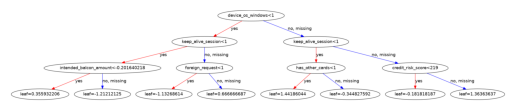

In [22]:
import xgboost as xgb
from xgboost import plot_tree
import matplotlib.pyplot as plt

# Train XGBoost with max_depth=3
xgb_cls = xgb.XGBClassifier(
    random_state=1234,
    max_depth=3,           # only 3 levels
    n_estimators=1,        # single tree for plotting
    learning_rate=1,       # high learning rate since we only use 1 tree
    subsample=1.0,
    colsample_bytree=1.0,
    scale_pos_weight=1
)
xgb_cls.fit(X_reduced, y)

# Plot the first (and only) tree
plt.figure(figsize=(18,10))
plot_tree(xgb_cls, num_trees=0, rankdir='TB')
plt.show()


## oost

## Gradient Search 

In [23]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score

# --- Step 1: Define classifier ---
xgb_cls = xgb.XGBClassifier(
    random_state=1234,
    use_label_encoder=False,  # suppress warning
    eval_metric='logloss',    # required for binary classification

)

# --- Step 2: Define hyperparameter grid ---
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 1, 5]
}

# --- Step 3: Define cross-validation ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)

# --- Step 4: Define scoring metric ---
scorer = make_scorer(f1_score)  # good for imbalanced data

# --- Step 5: GridSearchCV setup ---
grid_search = GridSearchCV(
    estimator=xgb_cls,
    param_grid=param_grid,
    scoring=scorer,
    cv=cv,
    n_jobs=-1,
    verbose=2
)

# --- Step 6: Fit on training data ---
grid_search.fit(X_reduced, y)  # X_reduced = training features

# --- Step 7: Best hyperparameters ---
print("Best Hyperparameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

# --- Step 8: Best estimator ---
best_xgb = grid_search.best_estimator_


Fitting 5 folds for each of 729 candidates, totalling 3645 fits


/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/tr

[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=500, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=500, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=500, subsample=1.0; total time=   0.1s


/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/tr

[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=500, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=500, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=500, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=500, subsample=1.0; total time=   0.1s


/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/tr

[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=500, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=500, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.0s
[

/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/tr

In [24]:
pip install optuna

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [25]:
%%time
import optuna
import xgboost as xgb
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score

# --- Define the Optuna objective function ---
def objective(trial):
    # Suggest hyperparameters
    max_depth = trial.suggest_int("max_depth", 3, 10)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3, log=True)
    n_estimators = trial.suggest_int("n_estimators", 100, 800, step=100)
    subsample = trial.suggest_float("subsample", 0.7, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.7, 1.0)
    gamma = trial.suggest_float("gamma", 0, 5)
    
    # Handle imbalanced classes
    scale_pos_weight = y.value_counts()[0] / y.value_counts()[1]

    # Define classifier
    xgb_cls = xgb.XGBClassifier(
        random_state=1234,
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        gamma=gamma,
        scale_pos_weight=scale_pos_weight,
        eval_metric='logloss',
        use_label_encoder=False
    )

    # Stratified CV
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)
    
    # Evaluate using weighted F1 score (good for fraud imbalance)
    score = cross_val_score(xgb_cls, X_reduced, y, cv=cv, scoring=make_scorer(f1_score))
    return score.mean()  # maximize F1

# --- Run Optuna study ---
sampler = optuna.samplers.TPESampler(seed=1234)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=50, show_progress_bar=True)

# --- Results ---
print("Best Parameters:", study.best_params)
print("Best CV F1 Score:", study.best_value)


[I 2026-01-23 22:53:50,684] A new study created in memory with name: no-name-93a7e342-92e1-4747-9f49-562629056c77


  0%|          | 0/50 [00:00<?, ?it/s]

/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/tr

[I 2026-01-23 22:53:50,947] Trial 0 finished with value: 0.7504169093411586 and parameters: {'max_depth': 4, 'learning_rate': 0.0829717191136948, 'n_estimators': 400, 'subsample': 0.9356075751141307, 'colsample_bytree': 0.933992742435641, 'gamma': 1.3629630264132082}. Best is trial 0 with value: 0.7504169093411586.


/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2026-01-23 22:53:51,290] Trial 1 finished with value: 0.7464704585446815 and parameters: {'max_depth': 5, 'learning_rate': 0.15291934777093275, 'n_estimators': 800, 'subsample': 0.9627797904226284, 'colsample_bytree': 0.80734518098736, 'gamma': 2.5049756276172936}. Best is trial 0 with value: 0.7504169093411586.


/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/tr

[I 2026-01-23 22:53:51,794] Trial 2 finished with value: 0.7482986943647394 and parameters: {'max_depth': 8, 'learning_rate': 0.11291387512427899, 'n_estimators': 300, 'subsample': 0.8683588558196875, 'colsample_bytree': 0.8509249495923429, 'gamma': 0.0688422479534112}. Best is trial 0 with value: 0.7504169093411586.
[I 2026-01-23 22:53:51,971] Trial 3 finished with value: 0.7536907202434324 and parameters: {'max_depth': 9, 'learning_rate': 0.20126490980313905, 'n_estimators': 300, 'subsample': 0.8846188535300481, 'colsample_bytree': 0.722614372492893, 'gamma': 1.8441200300098726}. Best is trial 3 with value: 0.7536907202434324.


/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/tr

[I 2026-01-23 22:53:52,197] Trial 4 finished with value: 0.7541062560262444 and parameters: {'max_depth': 10, 'learning_rate': 0.09165675979627692, 'n_estimators': 400, 'subsample': 0.9366190428822236, 'colsample_bytree': 0.7950508366506613, 'gamma': 2.840493263130346}. Best is trial 4 with value: 0.7541062560262444.


/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/tr

[I 2026-01-23 22:53:52,598] Trial 5 finished with value: 0.7631672055195866 and parameters: {'max_depth': 9, 'learning_rate': 0.044084004208671146, 'n_estimators': 700, 'subsample': 0.7431300473543694, 'colsample_bytree': 0.9112782913355006, 'gamma': 3.522906540947863}. Best is trial 5 with value: 0.7631672055195866.


/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/tr

[I 2026-01-23 22:53:52,800] Trial 6 finished with value: 0.7492234946997005 and parameters: {'max_depth': 4, 'learning_rate': 0.23234944103497734, 'n_estimators': 400, 'subsample': 0.9727947876917418, 'colsample_bytree': 0.7179427668339555, 'gamma': 0.9214354190690682}. Best is trial 5 with value: 0.7631672055195866.


/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/tr

[I 2026-01-23 22:53:53,037] Trial 7 finished with value: 0.7583798349193344 and parameters: {'max_depth': 3, 'learning_rate': 0.09928439327131382, 'n_estimators': 500, 'subsample': 0.8599930488996251, 'colsample_bytree': 0.712997218808441, 'gamma': 2.8071654003169892}. Best is trial 5 with value: 0.7631672055195866.
[I 2026-01-23 22:53:53,217] Trial 8 finished with value: 0.7543548114549228 and parameters: {'max_depth': 5, 'learning_rate': 0.055327748774862504, 'n_estimators': 100, 'subsample': 0.8821581118655454, 'colsample_bytree': 0.8697833929151594, 'gamma': 0.03382030995001395}. Best is trial 5 with value: 0.7631672055195866.


/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/tr

[I 2026-01-23 22:53:53,507] Trial 9 finished with value: 0.7561048814074266 and parameters: {'max_depth': 7, 'learning_rate': 0.22249287221059869, 'n_estimators': 700, 'subsample': 0.9976244398565084, 'colsample_bytree': 0.9876405286458599, 'gamma': 3.959820676458199}. Best is trial 5 with value: 0.7631672055195866.


/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2026-01-23 22:53:53,929] Trial 10 finished with value: 0.757591375681828 and parameters: {'max_depth': 10, 'learning_rate': 0.01707470546278658, 'n_estimators': 600, 'subsample': 0.7100439102215559, 'colsample_bytree': 0.9200282924663327, 'gamma': 4.739486462136874}. Best is trial 5 with value: 0.7631672055195866.


/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/tr

[I 2026-01-23 22:53:54,276] Trial 11 finished with value: 0.7548252262081585 and parameters: {'max_depth': 3, 'learning_rate': 0.025411444132964752, 'n_estimators': 600, 'subsample': 0.7652382316133914, 'colsample_bytree': 0.7777321262916895, 'gamma': 3.6343745853817815}. Best is trial 5 with value: 0.7631672055195866.


/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/tr

[I 2026-01-23 22:53:54,677] Trial 12 finished with value: 0.7680426839769009 and parameters: {'max_depth': 7, 'learning_rate': 0.035632553175899626, 'n_estimators': 600, 'subsample': 0.7984115899421017, 'colsample_bytree': 0.9015751518117002, 'gamma': 3.3839882962423085}. Best is trial 12 with value: 0.7680426839769009.


/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2026-01-23 22:53:55,119] Trial 13 finished with value: 0.7648071883622006 and parameters: {'max_depth': 7, 'learning_rate': 0.034315998368481974, 'n_estimators': 800, 'subsample': 0.7900233611069448, 'colsample_bytree': 0.9111822027897184, 'gamma': 3.725360363663741}. Best is trial 12 with value: 0.7680426839769009.


/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/tr

[I 2026-01-23 22:53:55,704] Trial 14 finished with value: 0.7558521974784165 and parameters: {'max_depth': 7, 'learning_rate': 0.011096553138158891, 'n_estimators': 800, 'subsample': 0.8043266725167587, 'colsample_bytree': 0.9773844600357476, 'gamma': 4.931669008307609}. Best is trial 12 with value: 0.7680426839769009.


/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/tr

[I 2026-01-23 22:53:56,095] Trial 15 finished with value: 0.7583951136461269 and parameters: {'max_depth': 6, 'learning_rate': 0.0314656372204027, 'n_estimators': 700, 'subsample': 0.8091145906833065, 'colsample_bytree': 0.8831678827112699, 'gamma': 4.12520528326498}. Best is trial 12 with value: 0.7680426839769009.


/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/tr

[I 2026-01-23 22:53:56,547] Trial 16 finished with value: 0.7631507277733904 and parameters: {'max_depth': 8, 'learning_rate': 0.02211423035183724, 'n_estimators': 600, 'subsample': 0.8121602171574184, 'colsample_bytree': 0.9474824451690731, 'gamma': 3.289243777915961}. Best is trial 12 with value: 0.7680426839769009.


/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2026-01-23 22:53:56,940] Trial 17 finished with value: 0.7635263459683349 and parameters: {'max_depth': 6, 'learning_rate': 0.04779368174114336, 'n_estimators': 800, 'subsample': 0.7773000872252949, 'colsample_bytree': 0.8242735607185296, 'gamma': 4.287712657131788}. Best is trial 12 with value: 0.7680426839769009.


/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/tr

[I 2026-01-23 22:53:57,618] Trial 18 finished with value: 0.7609238071160902 and parameters: {'max_depth': 8, 'learning_rate': 0.013338322559672437, 'n_estimators': 500, 'subsample': 0.7000146880858021, 'colsample_bytree': 0.8941942051769338, 'gamma': 1.8703679613494737}. Best is trial 12 with value: 0.7680426839769009.


/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/tr

[I 2026-01-23 22:53:58,077] Trial 19 finished with value: 0.7627681334355672 and parameters: {'max_depth': 7, 'learning_rate': 0.033888454175428205, 'n_estimators': 700, 'subsample': 0.8299609969695854, 'colsample_bytree': 0.9615450698530954, 'gamma': 3.1366094156066966}. Best is trial 12 with value: 0.7680426839769009.
[I 2026-01-23 22:53:58,198] Trial 20 finished with value: 0.7602530112970147 and parameters: {'max_depth': 6, 'learning_rate': 0.06306061504046445, 'n_estimators': 100, 'subsample': 0.745049900500963, 'colsample_bytree': 0.8425983938681476, 'gamma': 4.47995613968876}. Best is trial 12 with value: 0.7680426839769009.


/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/tr

[I 2026-01-23 22:53:58,601] Trial 21 finished with value: 0.7615971892889234 and parameters: {'max_depth': 6, 'learning_rate': 0.04051939956802436, 'n_estimators': 800, 'subsample': 0.7701061382334847, 'colsample_bytree': 0.8342820901011347, 'gamma': 4.126306825403204}. Best is trial 12 with value: 0.7680426839769009.


/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/tr

[I 2026-01-23 22:53:58,990] Trial 22 finished with value: 0.7630037125003051 and parameters: {'max_depth': 5, 'learning_rate': 0.06146878666263477, 'n_estimators': 800, 'subsample': 0.7818088262835398, 'colsample_bytree': 0.9013344387218427, 'gamma': 3.8537148943439825}. Best is trial 12 with value: 0.7680426839769009.


/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/tr

[I 2026-01-23 22:53:59,377] Trial 23 finished with value: 0.7593828165171995 and parameters: {'max_depth': 7, 'learning_rate': 0.019970059959772274, 'n_estimators': 600, 'subsample': 0.8347309035380774, 'colsample_bytree': 0.7487979343272886, 'gamma': 4.299081245788617}. Best is trial 12 with value: 0.7680426839769009.


/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/tr

[I 2026-01-23 22:53:59,800] Trial 24 finished with value: 0.7587102269877017 and parameters: {'max_depth': 6, 'learning_rate': 0.030165948987797793, 'n_estimators': 700, 'subsample': 0.7400215897479798, 'colsample_bytree': 0.8151051457197063, 'gamma': 3.1776755398404446}. Best is trial 12 with value: 0.7680426839769009.


/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:53:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/tr

[I 2026-01-23 22:54:00,206] Trial 25 finished with value: 0.7604598738644346 and parameters: {'max_depth': 8, 'learning_rate': 0.04394135987469191, 'n_estimators': 800, 'subsample': 0.7904388580875705, 'colsample_bytree': 0.8645659636659945, 'gamma': 4.584931286426957}. Best is trial 12 with value: 0.7680426839769009.


/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2026-01-23 22:54:00,482] Trial 26 finished with value: 0.7634382611727795 and parameters: {'max_depth': 9, 'learning_rate': 0.07636543021009963, 'n_estimators': 500, 'subsample': 0.8375472619207016, 'colsample_bytree': 0.9298156401409383, 'gamma': 3.6370336634475002}. Best is trial 12 with value: 0.7680426839769009.


/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2026-01-23 22:54:00,930] Trial 27 finished with value: 0.7485639740849319 and parameters: {'max_depth': 7, 'learning_rate': 0.03798238587448306, 'n_estimators': 700, 'subsample': 0.7570636264018459, 'colsample_bytree': 0.7793736479435476, 'gamma': 2.12940351642445}. Best is trial 12 with value: 0.7680426839769009.


/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/tr

[I 2026-01-23 22:54:01,520] Trial 28 finished with value: 0.7545368823257533 and parameters: {'max_depth': 5, 'learning_rate': 0.01533813399629717, 'n_estimators': 800, 'subsample': 0.7238472617782616, 'colsample_bytree': 0.8804253002659391, 'gamma': 2.8041177243426447}. Best is trial 12 with value: 0.7680426839769009.


/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/tr

[I 2026-01-23 22:54:01,844] Trial 29 finished with value: 0.7607152610809661 and parameters: {'max_depth': 4, 'learning_rate': 0.04999643652829817, 'n_estimators': 600, 'subsample': 0.786896203282132, 'colsample_bytree': 0.9511603183742126, 'gamma': 3.879941854586476}. Best is trial 12 with value: 0.7680426839769009.
[I 2026-01-23 22:54:02,029] Trial 30 finished with value: 0.758620238001567 and parameters: {'max_depth': 6, 'learning_rate': 0.07320651110685525, 'n_estimators': 300, 'subsample': 0.9012408383537948, 'colsample_bytree': 0.8216971528480704, 'gamma': 4.486236328681336}. Best is trial 12 with value: 0.7680426839769009.


/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/tr

[I 2026-01-23 22:54:02,312] Trial 31 finished with value: 0.7691375259142875 and parameters: {'max_depth': 9, 'learning_rate': 0.06923509043297814, 'n_estimators': 500, 'subsample': 0.826794518873978, 'colsample_bytree': 0.9310113048957522, 'gamma': 3.4835429867507055}. Best is trial 31 with value: 0.7691375259142875.


/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2026-01-23 22:54:02,568] Trial 32 finished with value: 0.7667401141435153 and parameters: {'max_depth': 9, 'learning_rate': 0.13537688521326816, 'n_estimators': 500, 'subsample': 0.8155297136033095, 'colsample_bytree': 0.9380436728675566, 'gamma': 3.4540697339613944}. Best is trial 31 with value: 0.7691375259142875.


/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/tr

[I 2026-01-23 22:54:02,820] Trial 33 finished with value: 0.762341667134294 and parameters: {'max_depth': 9, 'learning_rate': 0.17762572693888687, 'n_estimators': 500, 'subsample': 0.8146686668640052, 'colsample_bytree': 0.9369741533759377, 'gamma': 3.457111972180511}. Best is trial 31 with value: 0.7691375259142875.


/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/tr

[I 2026-01-23 22:54:03,054] Trial 34 finished with value: 0.7652157438235537 and parameters: {'max_depth': 10, 'learning_rate': 0.140012047335993, 'n_estimators': 400, 'subsample': 0.8451252470259171, 'colsample_bytree': 0.9678660224130304, 'gamma': 2.521582289054717}. Best is trial 31 with value: 0.7691375259142875.


/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/tr

[I 2026-01-23 22:54:03,289] Trial 35 finished with value: 0.7673880564764894 and parameters: {'max_depth': 10, 'learning_rate': 0.141925940417476, 'n_estimators': 400, 'subsample': 0.8485696721789722, 'colsample_bytree': 0.9713646219376025, 'gamma': 2.4240116945424104}. Best is trial 31 with value: 0.7691375259142875.
[I 2026-01-23 22:54:03,485] Trial 36 finished with value: 0.7432295005586991 and parameters: {'max_depth': 10, 'learning_rate': 0.12530850350310602, 'n_estimators': 200, 'subsample': 0.9048876249303308, 'colsample_bytree': 0.99230882207705, 'gamma': 1.2988689922372234}. Best is trial 31 with value: 0.7691375259142875.


/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/tr

[I 2026-01-23 22:54:03,712] Trial 37 finished with value: 0.7570094302860261 and parameters: {'max_depth': 9, 'learning_rate': 0.16051947298236835, 'n_estimators': 400, 'subsample': 0.8629448479367968, 'colsample_bytree': 0.9362100792193698, 'gamma': 2.287591290148713}. Best is trial 31 with value: 0.7691375259142875.


/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/tr

[I 2026-01-23 22:54:03,922] Trial 38 finished with value: 0.7601976951087501 and parameters: {'max_depth': 9, 'learning_rate': 0.280267289841035, 'n_estimators': 400, 'subsample': 0.8235715088538137, 'colsample_bytree': 0.9550970588639885, 'gamma': 2.920872840278566}. Best is trial 31 with value: 0.7691375259142875.


/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/tr

[I 2026-01-23 22:54:04,132] Trial 39 finished with value: 0.7508584937941156 and parameters: {'max_depth': 10, 'learning_rate': 0.1081178019245462, 'n_estimators': 300, 'subsample': 0.881407386796193, 'colsample_bytree': 0.9791911502882664, 'gamma': 2.516897459947114}. Best is trial 31 with value: 0.7691375259142875.


/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/tr

[I 2026-01-23 22:54:04,454] Trial 40 finished with value: 0.7540577340031136 and parameters: {'max_depth': 8, 'learning_rate': 0.09669508922514011, 'n_estimators': 500, 'subsample': 0.8517171126701661, 'colsample_bytree': 0.9207159024800672, 'gamma': 1.4209616207220481}. Best is trial 31 with value: 0.7691375259142875.


/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2026-01-23 22:54:04,687] Trial 41 finished with value: 0.7559779675206173 and parameters: {'max_depth': 10, 'learning_rate': 0.13637244085223058, 'n_estimators': 400, 'subsample': 0.8492732630756673, 'colsample_bytree': 0.9670616032089587, 'gamma': 2.538777334509458}. Best is trial 31 with value: 0.7691375259142875.


/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/tr

[I 2026-01-23 22:54:04,949] Trial 42 finished with value: 0.7618417307875467 and parameters: {'max_depth': 10, 'learning_rate': 0.14053648743994757, 'n_estimators': 500, 'subsample': 0.8451304041571317, 'colsample_bytree': 0.9698652877521364, 'gamma': 2.977641692276841}. Best is trial 31 with value: 0.7691375259142875.


/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/tr

[I 2026-01-23 22:54:05,191] Trial 43 finished with value: 0.763651877168386 and parameters: {'max_depth': 9, 'learning_rate': 0.08654681865009567, 'n_estimators': 400, 'subsample': 0.7999289541942174, 'colsample_bytree': 0.9934182780099617, 'gamma': 3.408472083709914}. Best is trial 31 with value: 0.7691375259142875.
[I 2026-01-23 22:54:05,377] Trial 44 finished with value: 0.7507641220600803 and parameters: {'max_depth': 9, 'learning_rate': 0.18079127590731575, 'n_estimators': 300, 'subsample': 0.8988253359266041, 'colsample_bytree': 0.9404410048975627, 'gamma': 2.173515922467467}. Best is trial 31 with value: 0.7691375259142875.


/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/tr

[I 2026-01-23 22:54:05,756] Trial 45 finished with value: 0.7488355924104818 and parameters: {'max_depth': 10, 'learning_rate': 0.11970764350162276, 'n_estimators': 500, 'subsample': 0.8721892627474195, 'colsample_bytree': 0.9185416465458464, 'gamma': 0.5459067426769615}. Best is trial 31 with value: 0.7691375259142875.
[I 2026-01-23 22:54:05,896] Trial 46 finished with value: 0.749986456840354 and parameters: {'max_depth': 9, 'learning_rate': 0.26414577259251093, 'n_estimators': 200, 'subsample': 0.82406207175261, 'colsample_bytree': 0.9025995205078438, 'gamma': 2.6684303898448705}. Best is trial 31 with value: 0.7691375259142875.


/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/tr

[I 2026-01-23 22:54:06,190] Trial 47 finished with value: 0.7575161289469495 and parameters: {'max_depth': 10, 'learning_rate': 0.19771737878503765, 'n_estimators': 600, 'subsample': 0.9345172590966735, 'colsample_bytree': 0.9800499709128524, 'gamma': 1.866292440291586}. Best is trial 31 with value: 0.7691375259142875.


/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2026-01-23 22:54:06,402] Trial 48 finished with value: 0.7565674733414808 and parameters: {'max_depth': 10, 'learning_rate': 0.22700935369006195, 'n_estimators': 400, 'subsample': 0.8602830307643271, 'colsample_bytree': 0.9513692813633239, 'gamma': 2.983616004376508}. Best is trial 31 with value: 0.7691375259142875.


/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2026-01-23 22:54:06,670] Trial 49 finished with value: 0.7687022270329159 and parameters: {'max_depth': 8, 'learning_rate': 0.15382893826719357, 'n_estimators': 500, 'subsample': 0.8183763411842939, 'colsample_bytree': 0.9246699955252753, 'gamma': 2.285484301295532}. Best is trial 31 with value: 0.7691375259142875.
Best Parameters: {'max_depth': 9, 'learning_rate': 0.06923509043297814, 'n_estimators': 500, 'subsample': 0.826794518873978, 'colsample_bytree': 0.9310113048957522, 'gamma': 3.4835429867507055}
Best CV F1 Score: 0.7691375259142875
CPU times: user 14.9 s, sys: 1.12 s, total: 16.1 s
Wall time: 16.2 s


/home/appij25/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [22:54:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


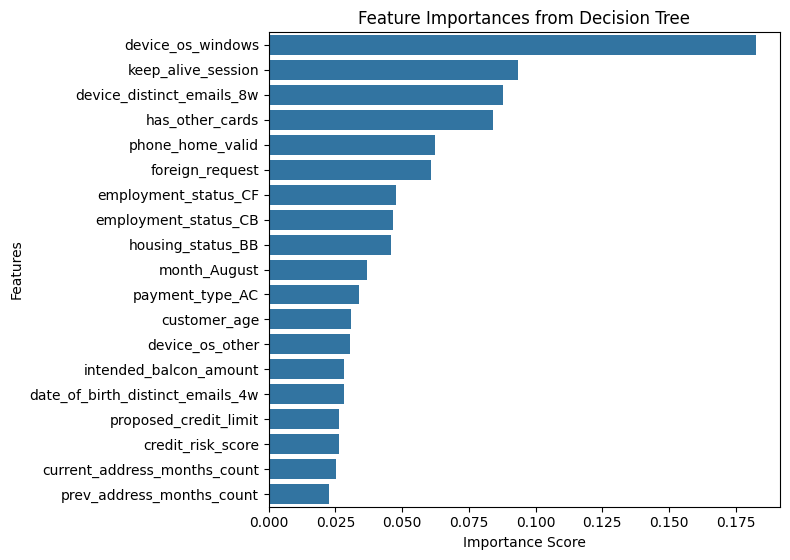

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
xgb_cls.fit(X_reduced, y)

# Get feature importances from trained tree
importances = xgb_cls.feature_importances_

# Create a Series with feature names from X_selected
feature_importances = pd.Series(importances, index=X_reduced.columns)
sorted_importances = feature_importances.sort_values(ascending=False)

# Plot
plt.figure(figsize=(8, len(sorted_importances) * 0.3))  # dynamic height
sns.barplot(x=sorted_importances.values, y=sorted_importances.index)
plt.title("Feature Importances from Decision Tree")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


In [27]:
print(sorted_importances)

device_os_windows                   0.182491
keep_alive_session                  0.093583
device_distinct_emails_8w           0.087856
has_other_cards                     0.084132
phone_home_valid                    0.062467
foreign_request                     0.060797
employment_status_CF                0.047530
employment_status_CB                0.046538
housing_status_BB                   0.045853
month_August                        0.036678
payment_type_AC                     0.033799
customer_age                        0.030897
device_os_other                     0.030457
intended_balcon_amount              0.028215
date_of_birth_distinct_emails_4w    0.028098
proposed_credit_limit               0.026471
credit_risk_score                   0.026166
current_address_months_count        0.025377
prev_address_months_count           0.022591
dtype: float32


In [28]:
# Class weights for imbalance
weight_1 = 1
weight_0 = (243434 / 757)  # adjust according to your dataset
sample_weights = np.where(y == 1, weight_1, weight_0)

# --------------------------
# 2. Train XGBoost with Optuna-best hyperparameters
# --------------------------
best_params = {
    "max_depth": 7,
    "learning_rate": 0.01997,
    "n_estimators": 600,
    "subsample": 0.8347,
    "colsample_bytree": 0.7488,
    "gamma": 4.299,
    "random_state": 1234,
    "eval_metric": "logloss",
}

xgb_cls2 = xgb.XGBClassifier(**best_params)
xgb_cls2.fit(X_reduced, y, sample_weight=sample_weights)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.7488
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


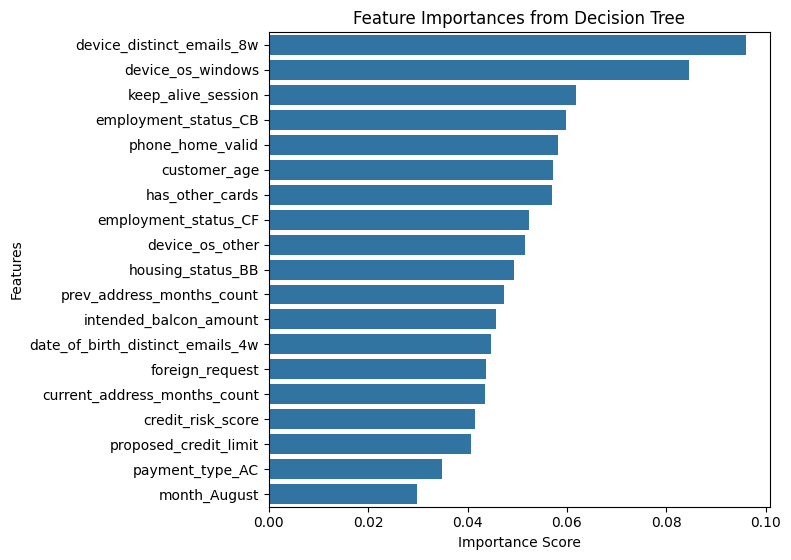

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances from trained tree
importances = xgb_cls2.feature_importances_

# Create a Series with feature names from X_selected
feature_importances = pd.Series(importances, index=X_reduced.columns)
sorted_importances = feature_importances.sort_values(ascending=False)

# Plot
plt.figure(figsize=(8, len(sorted_importances) * 0.3))  # dynamic height
sns.barplot(x=sorted_importances.values, y=sorted_importances.index)
plt.title("Feature Importances from Decision Tree")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


In [30]:
# --- Predict probabilities for the training set ---
train_o['pred_prob'] = xgb_cls2.predict_proba(X_reduced)[:, 1]  # probability of class 1 (fraud)

# Optional: preview
train_o[['pred_prob']].head()

,pred_prob
156658,0.000814
63213,0.000939
196385,0.000681
97557,0.000856
181264,0.000604


In [31]:
from sklearn.metrics import roc_auc_score

# --- Ensure we have predicted probabilities ---
# Already stored in train_o['pred_prob']
train_o['p_hat'] = train_o['pred_prob']  # probability of fraud = 1

# --- Compute ROC-AUC (C-statistic) ---
auc = roc_auc_score(train_o['fraud_bool'], train_o['p_hat'])
print("C-statistic (AUC):", auc)

# --- Compute Somer's D ---
somer_d = 2 * auc - 1
print("Somer's D:", somer_d)


C-statistic (AUC): 0.9822359999999999
Somer's D: 0.9644719999999998


In [32]:
from sklearn.metrics import roc_curve
import pandas as pd

# --- Ensure proper data types ---
y_true = train_o['fraud_bool'].astype(int)
y_score = train_o['p_hat'].astype(float)

# --- Check for both classes ---
if len(set(y_true)) < 2:
    raise ValueError("y_true has only one class. Need both positive and negative samples.")

# --- Compute ROC curve ---
fpr, tpr, thresholds = roc_curve(y_true, y_score)

# --- Compute Youden's J statistic ---
youden = pd.DataFrame({
    'TPR': tpr,
    'FPR': fpr,
    'Cut-off': thresholds,
    'Youden': tpr - fpr
})

# --- Sort by Youden's J ---
youden = youden.sort_values(by='Youden', ascending=False).reset_index(drop=True)

# --- Best cutoff ---
best_threshold = youden.loc[0, 'Cut-off']
print("Best threshold (Youden's J):", best_threshold)

# Optional: show top 5 thresholds
youden.head()


Best threshold (Youden's J): 0.0065058134496212006


,TPR,FPR,Cut-off,Youden
0,0.934,0.022,0.006506,0.912
1,0.936,0.024,0.006164,0.912
2,0.934,0.024,0.006354,0.910
3,0.930,0.020,0.006642,0.910
4,0.930,0.022,0.006552,0.908


In [33]:
import pandas as pd

# --- Convert predicted probabilities to class labels ---
# Use 0.5 cutoff; you can also replace 0.5 with best_threshold if desired
train_o['pred'] = train_o['pred_prob'].map(lambda x: 1 if x >0.0065058134496212006 else 0)

# --- Create confusion matrix ---
conf_matrix = pd.crosstab(train_o['fraud_bool'], train_o['pred'],
                          rownames=['Actual'], colnames=['Predicted'])

print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 Predicted    0    1
Actual             
0.0        489   11
1.0         34  466


In [34]:
from sklearn.metrics import roc_curve
import pandas as pd
import numpy as np

# --- True labels and predicted probabilities ---
y_true = train_o['fraud_bool'].astype(int)
y_score = train_o['p_hat'].astype(float)

# --- Business Costs ---
C_FN = 1200  # Cost of false negative (missed fraud)
C_FP_values = np.arange(700, 1001, 100)  # Costs of false positive (700 → 1000)

# --- Check for both classes ---
if len(set(y_true)) < 2:
    raise ValueError("y_true has only one class. Need both positive and negative samples.")

# --- Compute ROC curve ---
fpr, tpr, thresholds = roc_curve(y_true, y_score)

# --- Base counts ---
total_pos = sum(y_true)
total_neg = len(y_true) - total_pos

# --- Build DataFrame to store results ---
results = pd.DataFrame({
    'Threshold': thresholds,
    'TPR': tpr,
    'FPR': fpr
})

# --- Compute cost for each FP cost level ---
for C_FP in C_FP_values:
    results[f'Cost_FP{C_FP}'] = (
        (C_FP * results['FPR'] * total_neg) + 
        (C_FN * (1 - results['TPR']) * total_pos)
    )

# --- Find best threshold for each FP cost ---
best_thresholds = []
for C_FP in C_FP_values:
    col = f'Cost_FP{C_FP}'
    idx_min = results[col].idxmin()
    best_thresholds.append({
        'C_FP': C_FP,
        'Best_Threshold': results.loc[idx_min, 'Threshold'],
        'Min_Cost': results.loc[idx_min, col],
        'TPR': results.loc[idx_min, 'TPR'],
        'FPR': results.loc[idx_min, 'FPR']
    })

best_df = pd.DataFrame(best_thresholds)

print("✅ Optimal thresholds by false positive cost:")
print(best_df)


✅ Optimal thresholds by false positive cost:
   C_FP  Best_Threshold  Min_Cost    TPR    FPR
0   700        0.006164   46800.0  0.936  0.024
1   800        0.006164   48000.0  0.936  0.024
2   900        0.006164   49200.0  0.936  0.024
3  1000        0.006164   50400.0  0.936  0.024


✅ Optimal thresholds and cost savings vs baseline (threshold = 0.5):

   C_FP  Best_Threshold  Baseline_Cost  Min_Cost  Savings   TPR   FPR
0   700            0.01        66000.0   46800.0  19200.0  0.94  0.02
1   800            0.01        66000.0   48000.0  18000.0  0.94  0.02
2   900            0.01        66000.0   49200.0  16800.0  0.94  0.02
3  1000            0.01        66000.0   50400.0  15600.0  0.94  0.02


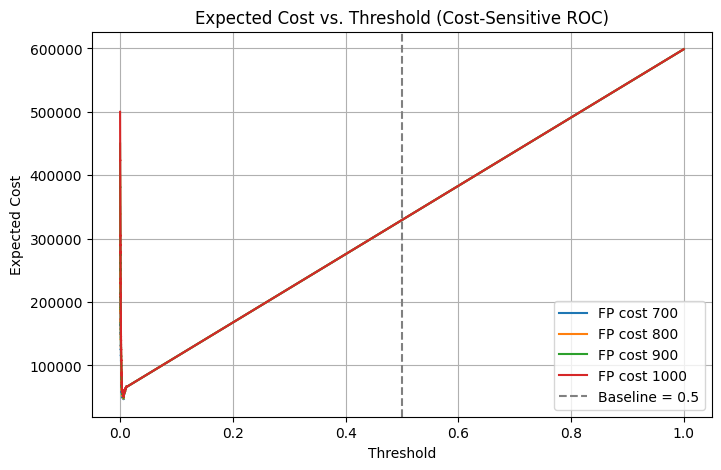

In [35]:
from sklearn.metrics import roc_curve
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Inputs ---
y_true = train_o['fraud_bool'].astype(int)
y_score = train_o['p_hat'].astype(float)

# --- Business Costs ---
C_FN = 1200                        # Cost of missing a fraud
C_FP_values = np.arange(700, 1001, 100)  # Cost range for false positives (700–1000)
baseline_threshold = 0.5           # Current operational cutoff

# --- Check for both classes ---
if len(set(y_true)) < 2:
    raise ValueError("y_true has only one class. Need both positive and negative samples.")

# --- Compute ROC curve ---
fpr, tpr, thresholds = roc_curve(y_true, y_score)
total_pos = sum(y_true)
total_neg = len(y_true) - total_pos

results = pd.DataFrame({
    'Threshold': thresholds,
    'TPR': tpr,
    'FPR': fpr
})

# --- Compute cost and compare to baseline ---
best_thresholds = []

# Baseline performance at threshold 0.5
baseline_idx = np.argmin(np.abs(thresholds - baseline_threshold))
baseline_tpr = tpr[baseline_idx]
baseline_fpr = fpr[baseline_idx]

for C_FP in C_FP_values:
    # Expected cost at each threshold
    results[f'Cost_FP{C_FP}'] = (
        (C_FP * results['FPR'] * total_neg) + 
        (C_FN * (1 - results['TPR']) * total_pos)
    )
    
    # Baseline cost
    baseline_cost = (
        (C_FP * baseline_fpr * total_neg) + 
        (C_FN * (1 - baseline_tpr) * total_pos)
    )
    
    # Minimum cost and corresponding threshold
    idx_min = results[f'Cost_FP{C_FP}'].idxmin()
    min_cost = results.loc[idx_min, f'Cost_FP{C_FP}']
    best_threshold = results.loc[idx_min, 'Threshold']
    
    # Savings = baseline_cost - min_cost
    savings = baseline_cost - min_cost
    
    best_thresholds.append({
        'C_FP': C_FP,
        'Best_Threshold': best_threshold,
        'Baseline_Cost': baseline_cost,
        'Min_Cost': min_cost,
        'Savings': savings,
        'TPR': results.loc[idx_min, 'TPR'],
        'FPR': results.loc[idx_min, 'FPR']
    })

best_df = pd.DataFrame(best_thresholds)

# --- Display results ---
print("✅ Optimal thresholds and cost savings vs baseline (threshold = 0.5):\n")
print(best_df.round(2))

# --- Plot cost curves ---
plt.figure(figsize=(8, 5))
for C_FP in C_FP_values:
    plt.plot(results['Threshold'], results[f'Cost_FP{C_FP}'], label=f'FP cost {C_FP}')
plt.axvline(baseline_threshold, color='gray', linestyle='--', label='Baseline = 0.5')
plt.xlabel('Threshold')
plt.ylabel('Expected Cost')
plt.title('Expected Cost vs. Threshold (Cost-Sensitive ROC)')
plt.legend()  # fixed legend
plt.grid(True)
plt.show()


✅ Cost-Optimized Threshold (C_FP = 820)
Optimal Threshold : 0.0062
True Positive Rate: 0.9360
False Positive Rate: 0.0240
Minimum Expected Cost: $48,240.00


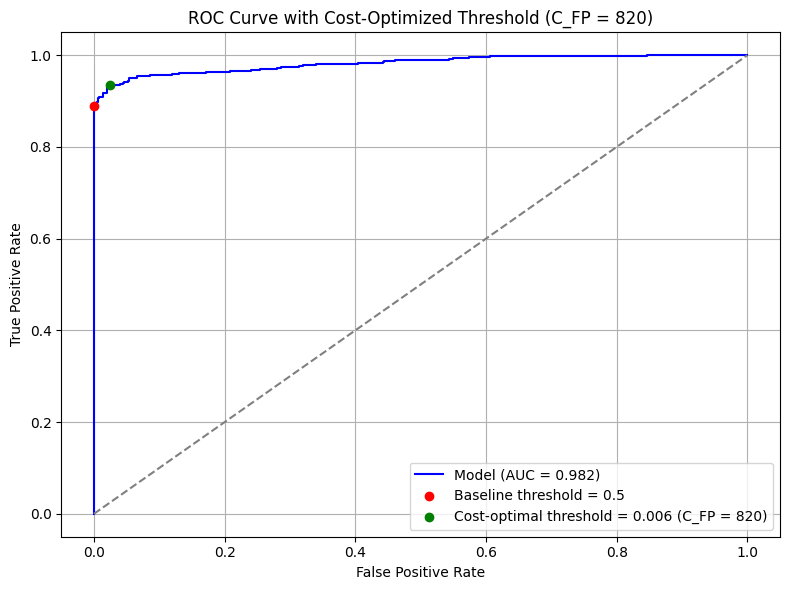

In [36]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# --- True labels and predicted probabilities ---
y_true = train_o['fraud_bool'].astype(int)
y_score = train_o['p_hat'].astype(float)

# --- ROC curve for all thresholds ---
fpr_model, tpr_model, thresholds_model = roc_curve(y_true, y_score)
auc_model = roc_auc_score(y_true, y_score)

# --- Business cost setup ---
C_FN = 1200   # Cost of false negative (missed fraud)
C_FP = 820    # Cost of false positive (wrongly flagged)

# --- Class counts ---
total_pos = sum(y_true)
total_neg = len(y_true) - total_pos

# --- Compute total expected business cost for each threshold ---
costs = (C_FP * fpr_model * total_neg) + (C_FN * (1 - tpr_model) * total_pos)

# --- Identify threshold minimizing total cost ---
idx_min = np.argmin(costs)
optimal_threshold = thresholds_model[idx_min]
optimal_fpr = fpr_model[idx_min]
optimal_tpr = tpr_model[idx_min]
optimal_cost = costs[idx_min]

# --- Print results ---
print("✅ Cost-Optimized Threshold (C_FP = 820)")
print(f"Optimal Threshold : {optimal_threshold:.4f}")
print(f"True Positive Rate: {optimal_tpr:.4f}")
print(f"False Positive Rate: {optimal_fpr:.4f}")
print(f"Minimum Expected Cost: ${optimal_cost:,.2f}")

# --- Plot ROC curve ---
plt.figure(figsize=(8, 6))

# Standard ROC curve
plt.plot(fpr_model, tpr_model, label=f"Model (AUC = {auc_model:.3f})", color='blue')

# Baseline threshold = 0.5 marker
baseline_idx = np.argmin(np.abs(thresholds_model - 0.5))
plt.scatter(
    fpr_model[baseline_idx],
    tpr_model[baseline_idx],
    color='red',
    label="Baseline threshold = 0.5",
    zorder=5
)

# Cost-optimized threshold marker
plt.scatter(
    optimal_fpr,
    optimal_tpr,
    color='green',
    label=f"Cost-optimal threshold = {optimal_threshold:.3f} (C_FP = 820)",
    zorder=5
)

# Chance line
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with Cost-Optimized Threshold (C_FP = 820)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


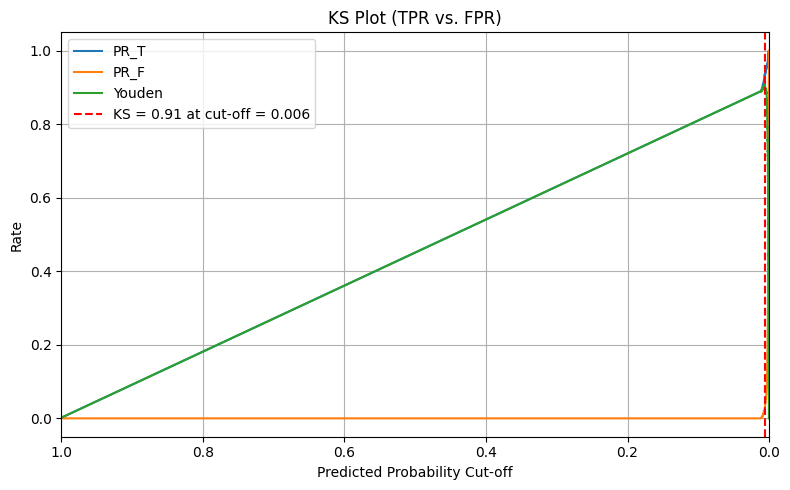

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve

# --- True labels and predicted probabilities ---
y_true = train_o['fraud_bool'].astype(int)
y_score = train_o['p_hat'].astype(float)

# --- Compute ROC curve ---
fpr, tpr, thresholds = roc_curve(y_true, y_score)

# --- Build Youden DataFrame ---
youden = pd.DataFrame({
    'Cut-off': thresholds,
    'TPR': tpr,
    'FPR': fpr,
    'Youden': tpr - fpr
})

# Sort by Cut-off ascending
youden = youden.sort_values(by='Cut-off', ascending=True)

# Prepare for plotting (melt for seaborn)
ks_stat = youden.rename(columns={'TPR': 'PR_T', 'FPR': 'PR_F'})
ks_stat = ks_stat.melt(id_vars='Cut-off', var_name='PR', value_name='value')

# KS statistic and cutoff
ks_val = youden['TPR'].sub(youden['FPR']).max()
ks_cutoff = youden.loc[(youden['TPR'] - youden['FPR']).idxmax(), 'Cut-off']

# --- Plot KS curve ---
plt.figure(figsize=(8, 5))
sns.lineplot(x='Cut-off', y='value', hue='PR', data=ks_stat)
plt.xlim(1, 0)  # decreasing threshold
plt.title("KS Plot (TPR vs. FPR)")
plt.xlabel("Predicted Probability Cut-off")
plt.ylabel("Rate")
plt.grid(True)
plt.axvline(x=ks_cutoff, linestyle='--', color='red', label=f'KS = {ks_val:.2f} at cut-off = {ks_cutoff:.3f}')
plt.legend()
plt.tight_layout()
plt.show()


In [38]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Arrays to store metrics
precision = []
recall = []
f1score = []

# Evaluate metrics across 0 → 0.99 thresholds
for y in range(100):
    cutoff = y / 100
    train_o['pred'] = (train_o['p_hat'] > cutoff).astype(int)
    
    precision.append(precision_score(train_o['fraud_bool'], train_o['pred']))
    recall.append(recall_score(train_o['fraud_bool'], train_o['pred']))
    f1score.append(f1_score(train_o['fraud_bool'], train_o['pred']))

# Create DataFrame
f1_s = pd.DataFrame({
    'Cut-off': np.arange(0, 1, 0.01),
    'Precision': precision,
    'Recall': recall,
    'F1': f1score
})

# Sort by F1 descending to find best threshold
best_f1 = f1_s.sort_values(by='F1', ascending=False)
print("Top thresholds by F1 score:\n")
print(best_f1.head(10))


Top thresholds by F1 score:

    Cut-off  Precision  Recall        F1
1      0.01   0.997773   0.896  0.944152
2      0.02   1.000000   0.860  0.924731
3      0.03   1.000000   0.844  0.915401
4      0.04   1.000000   0.830  0.907104
5      0.05   1.000000   0.812  0.896247
6      0.06   1.000000   0.796  0.886414
7      0.07   1.000000   0.786  0.880179
8      0.08   1.000000   0.774  0.872604
9      0.09   1.000000   0.756  0.861048
10     0.10   1.000000   0.746  0.854525


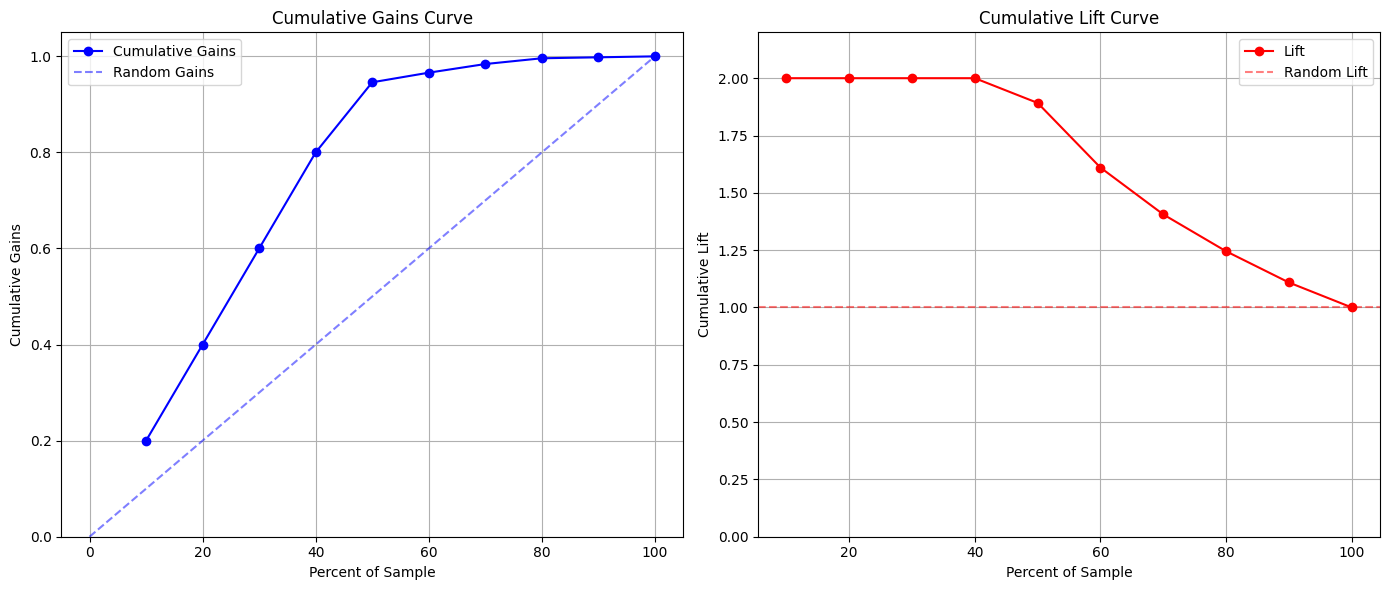

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_lift_and_gains(y_true, y_proba, n_bins=10):
    """
    Plot Lift and Cumulative Gains curves.

    Parameters:
    - y_true: array-like, true binary labels (0/1)
    - y_proba: array-like, predicted probabilities for the positive class
    - n_bins: number of bins/deciles to split data
    """
    df = pd.DataFrame({'y_true': y_true, 'y_proba': y_proba})
    
    # Sort descending by predicted probability
    df = df.sort_values(by='y_proba', ascending=False).reset_index(drop=True)
    
    # Cumulative totals
    df['cum_total'] = np.arange(1, len(df) + 1)
    df['cum_positives'] = df['y_true'].cumsum()
    
    total_positives = df['y_true'].sum()
    total_samples = len(df)
    
    # Cumulative Gains: % positives captured vs % samples
    df['cum_gains'] = df['cum_positives'] / total_positives
    
    # Lift: (cumulative gains) / (cumulative % of sample)
    df['cum_lift'] = df['cum_gains'] / (df['cum_total'] / total_samples)
    
    # Sample points for plotting (deciles)
    cutoffs = np.linspace(0, total_samples, n_bins + 1, dtype=int)[1:]  # skip 0
    plot_points = df.loc[cutoffs - 1, ['cum_total', 'cum_gains', 'cum_lift']].copy()
    plot_points['percent_samples'] = plot_points['cum_total'] / total_samples * 100
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Cumulative Gains Curve
    axes[0].plot(plot_points['percent_samples'], plot_points['cum_gains'], marker='o', color='blue', label='Cumulative Gains')
    axes[0].plot([0, 100], [0, 1], linestyle='--', color='blue', alpha=0.5, label='Random Gains')
    axes[0].set_xlabel('Percent of Sample')
    axes[0].set_ylabel('Cumulative Gains')
    axes[0].set_title('Cumulative Gains Curve')
    axes[0].set_ylim(0, 1.05)
    axes[0].grid(True)
    axes[0].legend()
    
    # Lift Curve
    axes[1].plot(plot_points['percent_samples'], plot_points['cum_lift'], marker='o', color='red', label='Lift')
    axes[1].axhline(1, linestyle='--', color='red', alpha=0.5, label='Random Lift')
    axes[1].set_xlabel('Percent of Sample')
    axes[1].set_ylabel('Cumulative Lift')
    axes[1].set_title('Cumulative Lift Curve')
    axes[1].set_ylim(0, plot_points['cum_lift'].max() * 1.1)
    axes[1].grid(True)
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

# Example usage:
plot_lift_and_gains(train_o['fraud_bool'], train_o['p_hat'])


## Testing 

In [40]:
test_o= test.copy()
num_cols_test = test_o.select_dtypes(include='number').columns

for col in num_cols_test:
    if test_o[col].isnull().any():
        # Create missing flag column
        test_o[f'{col}_was_missing'] = test_o[col].isnull().astype(int)

        # Impute with median
        median = test_o[col].median()
        test_o[col] = test_o[col].fillna(median)
print(test_o.columns)

Index(['fraud_bool', 'prev_address_months_count',
       'current_address_months_count', 'customer_age', 'days_since_request',
       'intended_balcon_amount', 'payment_type', 'velocity_6h', 'velocity_24h',
       'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'employment_status',
       'credit_risk_score', 'email_is_free', 'housing_status',
       'phone_home_valid', 'phone_mobile_valid', 'bank_months_count',
       'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'source',
       'session_length_in_minutes', 'device_os', 'keep_alive_session',
       'device_distinct_emails_8w', 'device_fraud_count', 'month',
       'email_domain', 'velocity_6h_was_missing'],
      dtype='object')


In [41]:
predictors_test = test_o.drop(columns=['fraud_bool'])
predictors_test = pd.get_dummies(predictors_test, drop_first=True)
predictors_test = predictors_test.astype(float)

train_columns = X_reduced.columns 

# Add missing columns in test set
for col in train_columns:
    if col not in predictors_test.columns:
        predictors_test[col] = 0

# Remove extra columns not in training
predictors_test = predictors_test[train_columns]

# Now X_test matches X_train exactly
X_test = predictors_test
y_test = test_o['fraud_bool']
X_test.head()

,phone_home_valid,has_other_cards,foreign_request,keep_alive_session,payment_type_AC,employment_status_CB,employment_status_CF,housing_status_BB,device_os_other,device_os_windows,month_August,prev_address_months_count,current_address_months_count,customer_age,intended_balcon_amount,date_of_birth_distinct_emails_4w,credit_risk_score,proposed_credit_limit,device_distinct_emails_8w
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,14.0,40.0,-1.490386,11.0,89.0,200.0,1.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,14.0,30.0,-1.863101,13.0,90.0,200.0,1.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,4.0,40.0,-0.544676,8.0,72.0,200.0,1.0
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,21.0,2.0,30.0,-0.955737,10.0,35.0,200.0,1.0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,13.0,114.0,20.0,-0.848347,18.0,49.0,200.0,2.0


In [42]:
from sklearn.metrics import (
    accuracy_score, roc_auc_score, recall_score,
    precision_score, f1_score, confusion_matrix, classification_report
)
import pandas as pd

def evaluate_classification(model, X, y, model_name, threshold=0.5):
    """
    Compute classification metrics for a given model and threshold.
    
    Parameters:
    - model: fitted model with predict_proba
    - X: features
    - y: true binary labels
    - model_name: string label for output
    - threshold: probability cutoff for binary prediction
    """
    # Predicted probabilities for positive class
    y_prob = model.predict_proba(X)[:, 1]
    
    # Convert probabilities to binary predictions using threshold
    y_pred = (y_prob >= threshold).astype(int)
    
    # Compute metrics
    accuracy = accuracy_score(y, y_pred)
    auc = roc_auc_score(y, y_prob)
    recall = recall_score(y, y_pred)
    precision = precision_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    
    # Confusion matrix and classification report
    cm = confusion_matrix(y, y_pred)
    report = classification_report(y, y_pred, digits=4)
    
    # Display results
    print(f"\n====== {model_name} CLASSIFICATION PERFORMANCE ======")
    print(f"Threshold: {threshold:.6f}")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"ROC-AUC  : {auc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1 Score : {f1:.4f}")
    
    print("\nConfusion Matrix:")
    print(cm)
    
    print("\nClassification Report:")
    print(report)
    
    # Return metrics as dictionary for further analysis
    metrics_dict = {
        'Model': model_name,
        'Threshold': threshold,
        'Accuracy': accuracy,
        'ROC-AUC': auc,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'ConfusionMatrix': cm,
        'ClassificationReport': report
    }
    
    return metrics_dict


In [43]:
metrics_XGboost  = evaluate_classification(xgb_cls2, X_test, y_test, "XGBooost", threshold=0.0065058134496212006)



====== XGBooost CLASSIFICATION PERFORMANCE ======
Threshold: 0.006506
Accuracy : 0.6758
ROC-AUC  : 0.8208
Precision: 0.0026
Recall   : 0.7977
F1 Score : 0.0052

Confusion Matrix:
[[164137  78797]
 [    52    205]]

Classification Report:
              precision    recall  f1-score   support

         0.0     0.9997    0.6756    0.8063    242934
         1.0     0.0026    0.7977    0.0052       257

    accuracy                         0.6758    243191
   macro avg     0.5011    0.7367    0.4057    243191
weighted avg     0.9986    0.6758    0.8055    243191



<Figure size 1000x600 with 0 Axes>

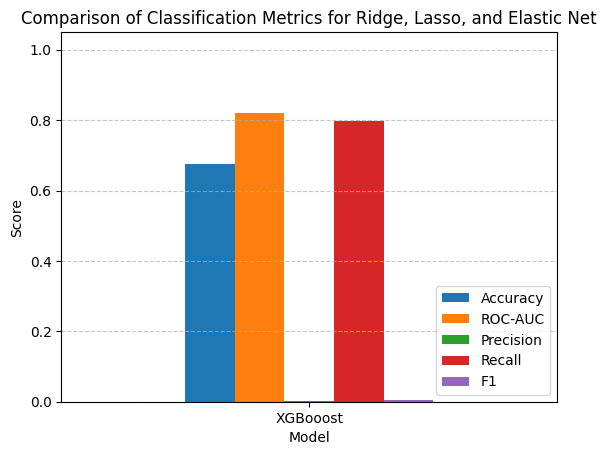

In [44]:
import matplotlib.pyplot as plt
import pandas as pd

# --- Collect metrics in a DataFrame ---
metrics_df = pd.DataFrame([
    metrics_XGboost
])

# Select only numeric metrics for plotting
plot_metrics = metrics_df[['Model', 'Accuracy', 'ROC-AUC', 'Precision', 'Recall', 'F1']]

# Set 'Model' as index
plot_metrics.set_index('Model', inplace=True)

# --- Plot ---
plt.figure(figsize=(10,6))
plot_metrics.plot(kind='bar', rot=0)
plt.title("Comparison of Classification Metrics for Ridge, Lasso, and Elastic Net")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='lower right')
plt.show()
